In [2]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.scan import PSScan, GBTPSScan
from copy import deepcopy
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from astropy.nddata import StdDevUncertainty
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import tsys_weight,average
from dysh.util import sq_weighted_avg
from dysh.plot.specplot import SpectrumPlot
from astropy.io import fits
from astropy.table import Table
import pandas as pd
pd.set_option('display.max_rows', 100)
from astropy.utils.data import get_pkg_data_filename
#%matplotlib notebook

-------------

# 1. GBTFITSLoad and position-switch calibration testing
change to use your specific `datadir`

In [3]:
datadir = '/data/gbt'
#f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + 'examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
#f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
p = GBTFITSLoad(f)
p.info()

Filename: /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   6040R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


In [ ]:
p.summary()

In [ ]:
p.summary(verbose=True)

In [ ]:
print(p.index(0)["EXPOSURE"].dtype, p.index(0)["CDELT1"].dtype)
tps = p.gettp(scan=152,sig=None,cal=None,bintable=0,ifnum=0,plnum=1)
print(tps._tsys_weight.dtype,tps.exposure.dtype,tps.delta_freq.dtype)

In [ ]:
print(p.index(0)["EXPOSURE"].dtype, p.index(0)["CDELT1"].dtype)
tps = p.gettp(scan=152,sig=None,cal=None,bintable=0,ifnum=0,plnum=1)
print(tps._tsys_weight.dtype,tps.exposure.dtype,tps.delta_freq.dtype)

-----------------------------
# Get total power scan integrations and plot the time average 

In [ ]:
tps = p.gettp(scan=153,sig=None,cal=None,bintable=0,ifnum=0,plnum=1)

In [ ]:
tps = p.gettp(scan=152,sig=True,cal=True,bintable=0,ifnum=0,plnum=1)
tps2 = p.gettp(scan=152,sig=True,cal=False,bintable=0,ifnum=0,plnum=1)
s=tps.timeaverage()
s.plot()
so = tps2.timeaverage()
so.plot()
print("TSYS(cal=T)=",s.meta['TSYS'])
print("TSYS(cal=F)=",so.meta['TSYS'])
s2 = (s+so)*0.5
s2.plot()
#(s-so).plot()
tpsc = p.gettp(scan=152,sig=True,cal=True,bintable=0,ifnum=0,plnum=1,calibrate=True)
s4=tpsc.timeaverage()
s4.plot()
s4.data-s.data
print(so.meta["TSYS"])

In [ ]:
tps.timeaverage(weights=None).plot()

In [ ]:
s=tps.timeaverage(weights=None)
s.plot()
s._plotter.figure.savefig("/home/mpound/src/dysh/docs/static/tp_153_eqweight.png")

In [ ]:

print('%s' % (np.array2string(tps.tsys,precision=2)))


In [ ]:
freq,counts=np.loadtxt("../testdata/tp152_if0_pl1_fd0.txt",skiprows=3,unpack=True)
freq=freq*1E9
#fig,ax=plt.subplots()
#ax.plot(freq,counts)
ss = s/2.0
s4.plot()
print(len(counts),len(freq))
freq+=np.mean(s.spectral_axis.value-freq)
s4._plotter.axis.plot(freq,counts,color='r')
freq[0]-freq[1]

## get another TP scan with different IF and Polarization and plot the 13th integration

In [ ]:
tps = p.gettp(scan=153,ifnum=1,plnum=1)
tps.total_power(12).plot()

In [ ]:
tps.timeaverage().plot()

## Try writing scans or records to FITS files and reading them back in


In [ ]:
scanlist = [152]

In [ ]:
p.write_scans("/tmp/scans.fits",overwrite=True,checksum=True,output_verify='fix',scans=scanlist)

In [ ]:
x1 = fits.open("/tmp/scans.fits")
x1.info()

In [ ]:
x1[1].header

In [ ]:
x1 = GBTFITSLoad("/tmp/scans.fits")
#x1._ptable[0]
x1._hdu.info()

In [ ]:
x1._hdu[1].header

In [ ]:
spec4 = p.getspec(4)
sp = SpectrumPlot(spec4)
sp.plot()

## Get a position switch scan and calibrate it.
The default ifnum=0, plnum=0

In [ ]:
# eventually this will have calibrate=True as the default, so you don't need to call calibrate().
psscan = p.getps(152)

In [ ]:
psscan.calibrate()

In [ ]:
xx=psscan.timeaverage()
type(psscan._calibrated)

### the raw calibrated numpy array

In [ ]:
psscan._calibrated

### A single integration of the calibrated Spectrum

In [ ]:
spec1 = psscan.calibrated(3)
sp = SpectrumPlot(spec1)
sp.plot(xaxis_unit="km/s")

### The average spectrum.  
You can plot with equal weights or $T_{sys}$ weighting (the default)
Compare this with GBTIDL `getps, 152`

In [ ]:
t=psscan.timeaverage(weights=None)
t.plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

In [ ]:
t=psscan.timeaverage(weights='tsys').plot()

### Try a different polarization and IF and use the OFF scan number
GBTIDL `getps, 153, ifnum=1, plnum=1`

In [ ]:
psscan = p.getps(152,plnum=1,ifnum=1)
psscan.calibrate()

In [ ]:
psscan.timeaverage().plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

### mixed FS and PS


In [ ]:
if False:
    datadir = '/data/gbt'
    f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
    p = GBTFITSLoad(f)
    p.info()
    p.summary()

--------------------------------

# SubbeamNOD KPFA Data 

In [4]:
datadir = "/data/gbt/"
f = datadir + 'examples/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits'
pnod = GBTFITSLoad(f)
pnod.info()
pnod._

Filename: /data/gbt/examples/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   5280R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '1024E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-04-13T03:58:07' / date and time this HDU was created            
ORIGIN  = 'NRAO Green Bank'    / origin of observation                          
TELESCOP= 'NRAO_GBT'           / the telescope used                             
INSTRUME= 'VEGAS   '           / backend                                        
SDFITVER= 'sdfits ver1.22'     / this file was created by sdfits                
FITSVER = '1.9     '           / FITS definition version                        

In [32]:
len(pnod._hdu[1].data[:]["DATA"][0])

1024

In [ ]:
vegas=np.array([0,32,64,96,128,160,192,224,256,288,320,352,384,416,448,480,544,576,608,640,672,
                704,736,768,800,832,864,896,928,960,992|0,32,64,96,128,160,192,224,256,288,320,
                352,384,416,448,480,544,576,608,640,672,704,736,768,800,832,864,896,928,960,992])

In [ ]:
tsysidl=np.array([84.9435,82.1865,88.1306,79.4702,83.3359,82.1568,
84.8032,87.5031,82.3827,86.6867,81.2290,83.3456,
154.525,76.3337,121.232,107.034,122.812,122.386,
109.684,126.385,106.435,116.182,120.199,117.069,
55.5695,70.8444,84.2473,84.2600,84.1720,85.6708,
83.8575,84.9475,85.0601,83.6906,82.5538,82.3467,
111.679,114.020,115.357,118.397,105.984,115.007,
113.603,113.097,116.426,115.867,114.906,118.247,
65.3346,72.2251,84.1646,83.3890,84.2675,83.7073,
83.2034,84.5122,84.7987,81.9806,83.8689,82.9380,
103.363,111.527,113.147,101.503,108.444,116.663,
111.407,113.278,115.310,115.436,114.451,117.825,
73.3529,71.0150,83.4908,84.2935,82.8866,83.5213,
85.0363,82.4940,82.6460,83.3778,82.8975,82.3562,
90.8207,139.061,101.555,105.921,110.831,112.511,
111.064,117.958,116.047,114.238,121.151,113.204,
74.1397,72.0670,84.6076,84.3983,83.6667,84.0574,
82.1753,81.9777,82.7533,83.2628,83.1251,84.4301,
72.5894,138.020,105.265,103.819,112.595,115.162,
116.772,115.474,114.101,114.157,115.170,112.846,
])
#len(tsysidl)     120                                                                                                             
      

In [ ]:
subrefdata=[0,0]
subreffreq=[0,0]

In [ ]:
f,d = np.loadtxt("/home/mpound/subref-1.ascii",skiprows=3,unpack=True)
subreffreq[0] =f
subrefdata[0] =d

In [ ]:
f,d = np.loadtxt("/home/mpound/subref+1.ascii",skiprows=3,unpack=True)
subreffreq[1] =f
subrefdata[1] =d

In [ ]:
snodka_43 = np.loadtxt("/home/mpound/snod43_if0_fd1_pl0.ascii",skiprows=3,unpack=True)

In [ ]:
92*6198*(subrefdata[1]-subrefdata[0])/subrefdata[0]

In [6]:
ifnum=0
plnum=0
fdnum=1
scan=43
bintable=0
weights='tsys'
cal=None

In [ ]:

tp1=pnod.gettp(scan,cal=cal,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,calibrate=True,subref=-1)
np.mean(np.abs(tp1.tsys))
#np.mean(tp1.tsys,where=((tp1.tsys>0) and (tp1.tsys<100)))
#w=np.where((tp1.tsys>0) &(tp1.tsys<100))[0]
#np.mean(tp1.tsys)
#np.shape(tp1.data)

In [ ]:
tpa=tp1.timeaverage()
tpa.plot()
tpa.meta['TSYS']

In [ ]:
subref=-1
print(tp1.timeaverage().meta["TCAL"])
df=pnod._ptable[0][pnod._ptable[0]["SCAN"].isin([43])]
len(df)
len(df[(df["PLNUM"]==plnum) & (df["FDNUM"] == fdnum) & ( df["SUBREF_STATE"] == subref)])

In [ ]:
#scan=43
tsys = {43:92.6198,46:91.72}
#bintable=0
print(weights)
tpp = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum)
tpon  = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=-1)
tpoff = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=1)
on  =  tpon.timeaverage(weights=weights)
off = tpoff.timeaverage(weights=weights)
if False:
    print(f"ON TCAL: {on.meta['TCAL']} OFF TCAL: {off.meta['TCAL']}")
    print(f"ON TSYS: {on.meta['TSYS']} OFF TSYS: {off.meta['TSYS']}")
    print(f"ON WTTSYS: {on.meta['WTTSYS']} OFF WTTSYS: {off.meta['WTTSYS']}")
    print(f"ON MEANTSYS: {on.meta['MEANTSYS']} OFF MEANTSYS: {off.meta['MEANTSYS']}")
    print("AVEG ",0.5*(on.meta['TSYS']+off.meta['TSYS']))
idl=tsys[scan]*(on-off)/off
#idl = tpp.timeaverage(weights=weights).meta['TSYS']*(on-off)/off
print(tpp.timeaverage(weights=weights).meta['TSYS'])
idl.plot()

In [ ]:
idl.data

In [ ]:
tsys = {43:92.6168,46:91.72}
#bintable=0
print(weights)
tpp = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum)
tpon  = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=-1,calibrate=True)
tpoff = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=1,calibrate=True)
#on  =  tpon.total_power(0)
#off = tpoff.total_power(0)
tpon.calc_tsys()
print(tpon._tsys_weight)
on = tpon.timeaverage(weights=None)
off = tpoff.timeaverage(weights=None)
if False:
    print(f"ON TCAL: {on.meta['TCAL']} OFF TCAL: {off.meta['TCAL']}")
    print(f"ON TSYS: {on.meta['TSYS']} OFF TSYS: {off.meta['TSYS']}")
    print(f"ON WTTSYS: {on.meta['WTTSYS']} OFF WTTSYS: {off.meta['WTTSYS']}")
    print(f"ON MEANTSYS: {on.meta['MEANTSYS']} OFF MEANTSYS: {off.meta['MEANTSYS']}")
    print("AVEG ",0.5*(on.meta['TSYS']+off.meta['TSYS']))
idl=tsys[scan]*(on-off)/off
#idl = tpp.timeaverage(weights=weights).meta['TSYS']*(on-off)/off
print(tpp.timeaverage(weights=weights).meta['TSYS'])
idl.plot()

In [ ]:
tpoff.timeaverage().meta["TSYS"]

In [ ]:
len(tpon._tsys_weight)

In [9]:
fn=get_pkg_data_filename("../src/dysh/spectra/tests/data/snodka_43_int_1_fdnum_1_ifnum_0.fits")
hdu=fits.open(fn)
xx = hdu[1].data["DATA"][0]
len(xx)

1024

In [ ]:
sdf=GBTFITSLoad(fn)
sdf.summary()
spec1=sdf.getspec(0)
spec1.plot()
np.mean(spec1.data-idl.data)

In [ ]:
fix,ax=plt.subplots()
ax.plot(spec1.spectral_axis,spec1.data-idl.data)

In [ ]:
tpon.total_power(0).plot()
tpoff.total_power(0).plot()
(0.5*(tpon.total_power(0)+tpoff.total_power(0))).plot()

In [ ]:
print(scan,ifnum,plnum,fdnum,weights)
os = pnod.gettp(scan=scan,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights=None,calbrate=True)
np.mean(np.abs(os.tsys)),os.tsys,len(os.tsys),len(tsysidl)
#os.timeaverage().meta['TSYS']

In [ ]:
print(scan)
se=pnod.subbeamnod(scan=scan,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights=None)
print(se.meta['TSYS'])

In [ ]:
fn=get_pkg_data_filename("../src/dysh/spectra/tests/data/TRCO_230413_Ka_snodka_43_ifnum_0_plnum_0_fdnum_1.fits")
hdu=fits.open(fn)
xx = hdu[1].data["DATA"][0]
len(xx)
np.nanmedian(xx-snodka_43[1])

In [ ]:
fn=get_pkg_data_filename("../src/dysh/spectra/tests/data/test2.fits")
hdu=fits.open(fn)
x = hdu[1].data["DATA"][0]
len(x)

In [ ]:
gbt=GBTFITSLoad(fn)
gbt.summary()
tp=gbt.gettp(43)
spec=gbt.getspec(0)
spec.plot()
se._unit = u.ct

In [ ]:
(se-s).plot()

In [7]:
s=pnod.subbeamnod(scan=scan,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights='equal',calibrate=True)
s._unit = u.ct

TPSCAN nrows = 22
# scanrows 22, # calrows ON 11  # calrows OFF 11
TPSCAN nrows = 20
# scanrows 20, # calrows ON 10  # calrows OFF 10
TPSCAN nrows = 16
# scanrows 16, # calrows ON 8  # calrows OFF 8
TPSCAN nrows = 20
# scanrows 20, # calrows ON 10  # calrows OFF 10
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 18
# scanrows 18, # calrows ON 9  # calrows OFF 9
TPSCAN nrows = 20
# scanrows 20, # calrows ON 10  # calrows OFF 10


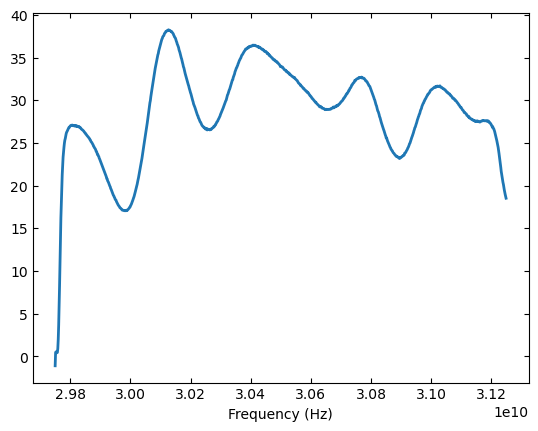

In [8]:
s.plot()

In [ ]:
print(np.nanmedian(se.flux.value-x))
se.meta['TSYS']
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,se.flux.value-x)
fig.savefig("diffequal.png")

In [ ]:
se.data,xx

In [ ]:
print(np.nanmedian(s.data-snodka_43[1]))
xx=snodka_43[1]
print(np.nanmedian(s._spectral_axis.to("GHz").value-snodka_43[0]))

18.373177240151747


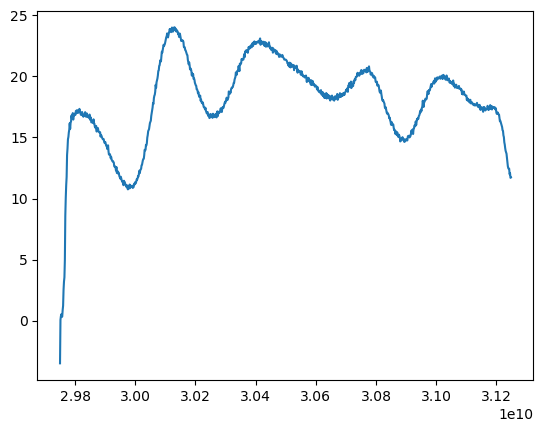

In [10]:
print(np.nanmedian(s.flux.value-xx))
s.meta['TSYS']
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.data-xx)
#fig.savefig("difftsyswt.png")

In [ ]:
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,100*(s.flux.value-xx)/xx)
#ax.set_ylim(-0.50,0.5)
ax.set_ylabel("Percent difference")
fig.savefig("subbeammod_tsysweight_diff.png")

In [ ]:
fig,ax=plt.subplots()
ax.plot(se.spectral_axis,100*(se.flux.value-x)/x)
ax.set_ylim(-0.50,0.5)
ax.set_ylabel("Percent difference")
fig.savefig("subbeammod_eqweight_diff.png")

# np.nanmedian(se.flux.value-x)

In [ ]:
se.plot()
#s._plotter.axis.plot(s.spectral_axis,x,color='r')
fix,ax=plt.subplots()
ax.plot(se.spectral_axis,x,color='r')

In [ ]:
print(s.stats())
s.plot()
diff=s/idl
diff.plot()
print(diff.data)
print(diff.stats())
print(s.meta['TSYS']/tsys[scan],s.meta['TSYS']-tsys[scan])

In [ ]:
np.nanmedian(idl.flux.value-x),np.nanmedian(diff.data)

-----
# Debugging from here down.